# Centroid Accuracy

### Motivation
In this notebook we will look at how the Zernike polynomial estimation performance from the Wavefront Estimation Calculation changes as the accuracy of the star location worsens. The motivation for this is to test how accurate the WCS used in practice needs to be.

### Experiment Design
To do this we will create different catalogs for the phosim donut generation and the wavefront analysis where the analysis catalogs have star positions slightly offset.

For example, here is a line from the actual star catalog used to create the phosim output:

```
# Id	 Ra		 Decl		 Mag
0	 359.765300	 -0.234700	 15.000000
1	 359.765300	 0.000000	 15.000000
2	 359.765300	 0.234700	 15.000000
```

and here is a sample of the corresponding input catalog that is provided to the `ts_wep` code that has the positions of the stars shifted by 20 pixels:

```
# Id	 Ra		 Decl		 Mag
0	 359.766411	 -0.234700	 15.000000
1	 359.766411	 0.000000	 15.000000
2	 359.766411	 0.234700	 15.000000
```

### Performance Metric
Our performance metric in this first version will be the RMS value between OPD results and the Zernike polynomials given by `ts_wep` output.

### Test data
The test data was created running on the UW *epyc* machine using `runCentroidAnalysis.py` in the `ts_phosim/notebooks/analysis_scripts` directory.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('../analysis_tools/')
from calcMetrics import calcMetrics

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data_dir = '/astro/store/epyc/projects/lsst_comm/ts_phosim/notebooks/analysis_data/centroid_offsets/noBaseOffset/'

In [5]:
calcCentroidMetrics = calcMetrics()

## Offsets in the y-direction

In this test we offset the star database values in the direction along the long axis of the amplifiers. After 40 pixels the offset is too large to get a postage stamp with enough of the donut to remeasure the center. This corresponds to errors of greater than 40 pixels * 0.2 arcsec/pixel = 8 arcsec.

In [6]:
offset_array = np.arange(-40, 41, 10)
ang_array = [0]*len(offset_array)
ssrTotalVals = []
ssrFieldVals = []
for offset, ang in zip(offset_array, ang_array):
    opdZkFilePath = os.path.join(data_dir, 'opd.zer.centroid.%iang%i' % (offset, ang))
    wfsZkFilePath = os.path.join(data_dir, 'wfs.zer.centroid.%iang%i' % (offset, ang))
    opdData, wfsData = calcCentroidMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    zerFieldSSR, zerTotalSSR = calcCentroidMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

(array([0.564639  , 0.56463925, 0.5646395 , 0.56463975, 0.56464   ,
        0.56464025, 0.5646405 , 0.56464075, 0.564641  , 0.56464125,
        0.5646415 ]), <a list of 11 Text yticklabel objects>)

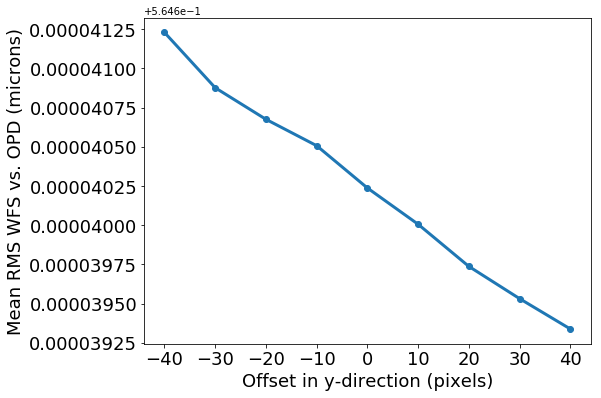

In [7]:
fig = plt.figure(figsize=(8,6))
plt.plot(offset_array, np.sqrt(np.array(ssrTotalVals)/9), '-o', lw=3)
plt.xlabel('Offset in y-direction (pixels)', size=18)
plt.ylabel('Mean RMS WFS vs. OPD (microns)', size=18)
plt.xticks(size=18)
plt.yticks(size=18)

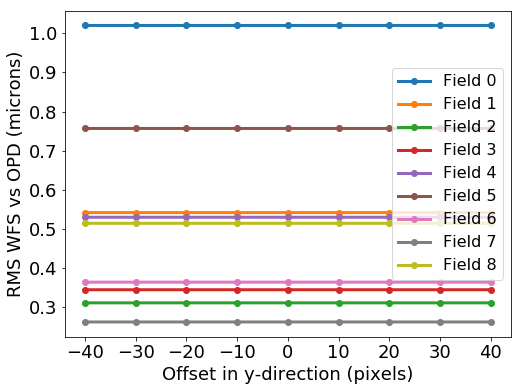

In [8]:
fig = plt.figure(figsize=(8,6))
for i in range(9):
    plt.plot(offset_array, np.sqrt(np.array(ssrFieldVals)[:, i]), '-o', lw=3, label='Field %i' % i)
plt.xlabel('Offset in y-direction (pixels)', size=18)
plt.ylabel('RMS WFS vs OPD (microns)', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.legend(fontsize=16)

### Generate CCD map of error values

In [9]:
starCat = np.genfromtxt(os.path.join(data_dir, 'perturbStarCat.0ang0.txt'), names=['field', 'ra', 'dec', 'mag'])

In [10]:
starCat['ra'][:3] = starCat['ra'][:3] - 360.

Text(0.5, 1.0, 'Mean Errors in Each CCD')

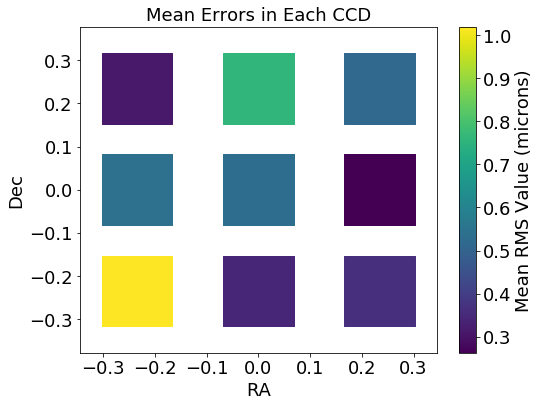

In [11]:
fig = plt.figure(figsize=(8,6))
plt.scatter(starCat['ra'], starCat['dec'], c=np.mean(np.sqrt(np.array(ssrFieldVals)), axis=0), s=5000, marker='s')
plt.xlabel('RA', size=18)
plt.ylabel('Dec', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
cbar = plt.colorbar()
cbar.set_label('Mean RMS Value (microns)', size=18)
cbar.ax.tick_params(labelsize=18)
plt.title('Mean Errors in Each CCD', size=18)

## Offsets in the x-direction

Here we create an error in the star database used by the wavefront estimation code in the direction along the short axis of the amplifiers.

In [12]:
offset_array = np.arange(-40, 41, 10)
ang_array = [90]*len(offset_array)
ssrTotalVals = []
ssrFieldVals = []
for offset, ang in zip(offset_array, ang_array):
    opdZkFilePath = os.path.join(data_dir, 'opd.zer.centroid.%iang%i' % (offset, ang))
    wfsZkFilePath = os.path.join(data_dir, 'wfs.zer.centroid.%iang%i' % (offset, ang))
    opdData, wfsData = calcCentroidMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    zerFieldSSR, zerTotalSSR = calcCentroidMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

(array([0.56463875, 0.564639  , 0.56463925, 0.5646395 , 0.56463975,
        0.56464   , 0.56464025, 0.5646405 , 0.56464075, 0.564641  ,
        0.56464125]), <a list of 11 Text yticklabel objects>)

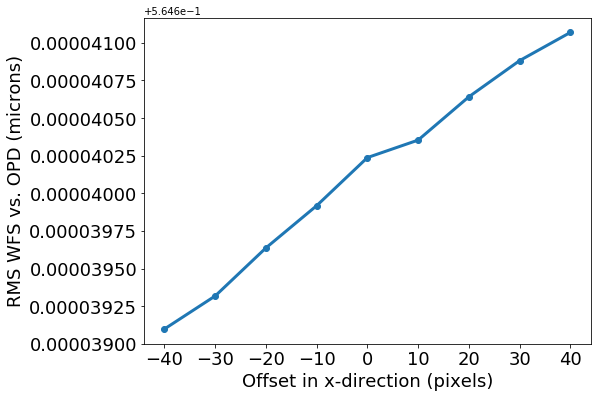

In [13]:
fig = plt.figure(figsize=(8,6))
plt.plot(offset_array, np.sqrt(np.array(ssrTotalVals)/9), '-o', lw=3)
plt.xlabel('Offset in x-direction (pixels)', size=18)
plt.ylabel('RMS WFS vs. OPD (microns)', size=18)
plt.xticks(size=18)
plt.yticks(size=18)

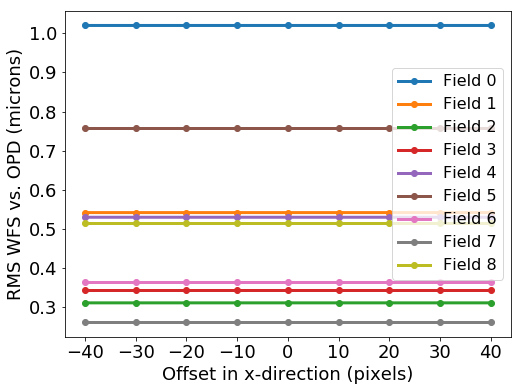

In [14]:
fig = plt.figure(figsize=(8,6))
for i in range(9):
    plt.plot(offset_array, np.sqrt(np.array(ssrFieldVals)[:, i]), '-o', lw=3, label='Field %i' % i)
plt.xlabel('Offset in x-direction (pixels)', size=18)
plt.ylabel('RMS WFS vs. OPD (microns)', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.legend(fontsize=16)

Text(0.5, 1.0, 'Mean Errors in Each CCD')

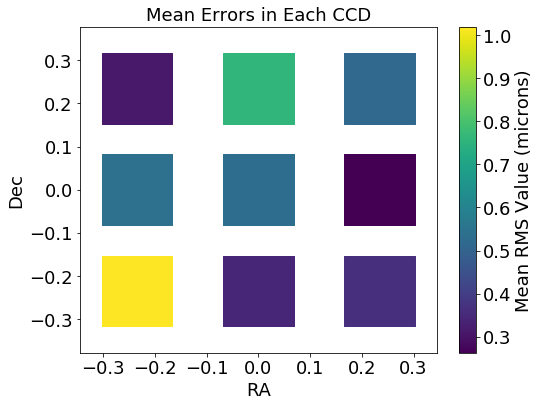

In [15]:
fig = plt.figure(figsize=(8,6))
plt.scatter(starCat['ra'], starCat['dec'], c=np.mean(np.sqrt(np.array(ssrFieldVals)), axis=0), s=5000, marker='s')
plt.xlabel('RA', size=18)
plt.ylabel('Dec', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
cbar = plt.colorbar()
cbar.set_label('Mean RMS Value (microns)', size=18)
cbar.ax.tick_params(labelsize=18)
plt.title('Mean Errors in Each CCD', size=18)

## Offsets in random directions

Here we offset in random directions by different pixel distances.

In [16]:
offset_array = np.arange(0, 51, 10)
ang_array = [8, 128, 167, 117, 104, 228]
ssrTotalVals = []
ssrFieldVals = []
for offset, ang in zip(offset_array, ang_array):
    opdZkFilePath = os.path.join(data_dir, 'opd.zer.centroid.%iang%i' % (offset, ang))
    wfsZkFilePath = os.path.join(data_dir, 'wfs.zer.centroid.%iang%i' % (offset, ang))
    opdData, wfsData = calcCentroidMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    zerFieldSSR, zerTotalSSR = calcCentroidMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

(array([0.5646398, 0.56464  , 0.5646402, 0.5646404, 0.5646406, 0.5646408,
        0.564641 , 0.5646412, 0.5646414, 0.5646416]),
 <a list of 10 Text yticklabel objects>)

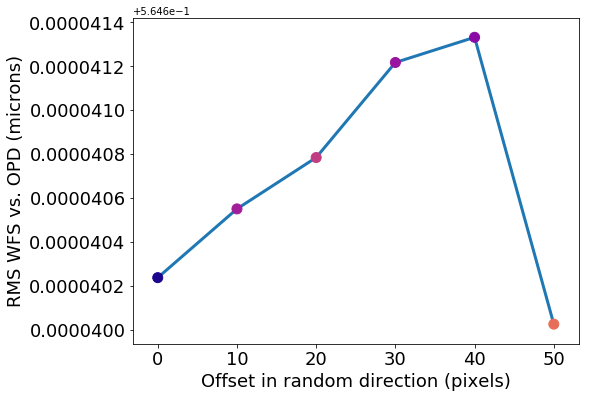

In [17]:
fig = plt.figure(figsize=(8,6))
plt.plot(offset_array, np.sqrt(np.array(ssrTotalVals)/9), '-o', lw=3)
plt.scatter(offset_array, np.sqrt(np.array(ssrTotalVals)/9), c=ang_array, zorder=10, s=100, cmap=plt.get_cmap('plasma'), vmin=0, vmax=360)
plt.xlabel('Offset in random direction (pixels)', size=18)
plt.ylabel('RMS WFS vs. OPD (microns)', size=18)
plt.xticks(size=18)
plt.yticks(size=18)

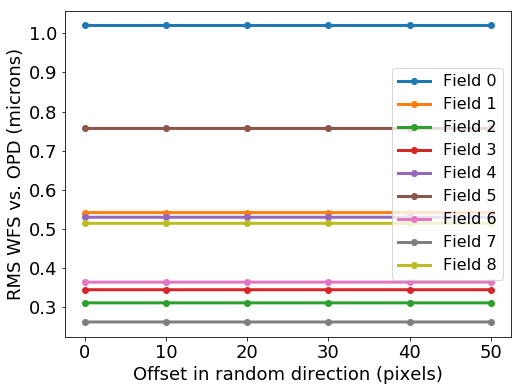

In [18]:
fig = plt.figure(figsize=(8,6))
for i in range(9):
    plt.plot(offset_array, np.sqrt(np.array(ssrFieldVals)[:, i]), '-o', lw=3, label='Field %i' % i)
plt.xlabel('Offset in random direction (pixels)', size=18)
plt.ylabel('RMS WFS vs. OPD (microns)', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.legend(fontsize=16)

Text(0.5, 1.0, 'Mean Errors in Each CCD')

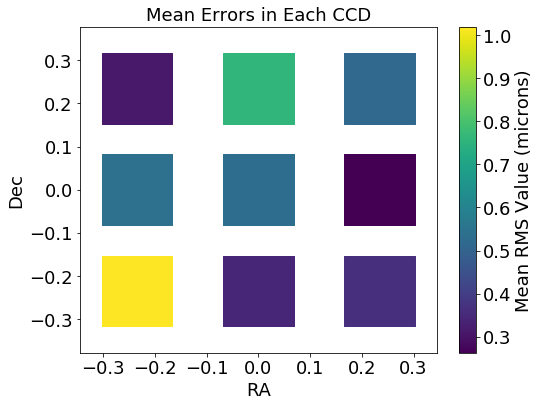

In [19]:
fig = plt.figure(figsize=(8,6))
plt.scatter(starCat['ra'], starCat['dec'], c=np.mean(np.sqrt(np.array(ssrFieldVals)), axis=0), s=5000, marker='s')
plt.xlabel('RA', size=18)
plt.ylabel('Dec', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
cbar = plt.colorbar()
cbar.set_label('Mean RMS Value (microns)', size=18)
cbar.ax.tick_params(labelsize=18)
plt.title('Mean Errors in Each CCD', size=18)

## Example Offset

We saved a cutout image below before it is corrected for an offset of 20 pixels. (Inserted code to save stamp in line 371 of `WepController.py`)

In [20]:
ex = np.loadtxt(os.path.join(data_dir, 'stamp20PixOffset.out'))

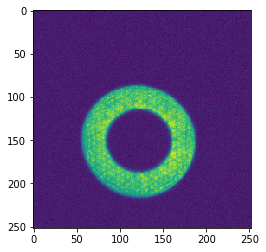

In [21]:
plt.imshow(ex)

## Testing donuts off center of CCD

In the original tests above the star location was at the exact middle of the CCD. The errors seen when doing this were higher than expected so we wanted to move the star to a different portion of the CCD to see if there was a change.

Here we rerun the test for the y offsets but move the donuts off the center of the CCD to avoid the charge block in the middle of the chip and see if there is a difference.

In [22]:
data_dir = '/astro/store/epyc/projects/lsst_comm/ts_phosim/notebooks/analysis_data/centroid_offsets/150x150yOffset'

In [23]:
offset_array = np.arange(-40, 41, 10)
ang_array = [0]*len(offset_array)
ssrTotalVals = []
ssrFieldVals = []
for offset, ang in zip(offset_array, ang_array):
    opdZkFilePath = os.path.join(data_dir, 'opd.zer.centroid.%iang%i' % (offset, ang))
    wfsZkFilePath = os.path.join(data_dir, 'wfs.zer.centroid.%iang%i' % (offset, ang))
    opdData, wfsData = calcCentroidMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    zerFieldSSR, zerTotalSSR = calcCentroidMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

(array([0.25882804, 0.25882806, 0.25882808, 0.2588281 , 0.25882812,
        0.25882814, 0.25882816]), <a list of 7 Text yticklabel objects>)

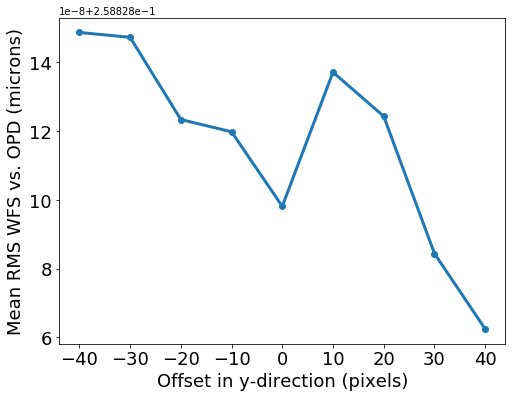

In [24]:
fig = plt.figure(figsize=(8,6))
plt.plot(offset_array, np.sqrt(np.array(ssrTotalVals)/9), '-o', lw=3)
plt.xlabel('Offset in y-direction (pixels)', size=18)
plt.ylabel('Mean RMS WFS vs. OPD (microns)', size=18)
plt.xticks(size=18)
plt.yticks(size=18)

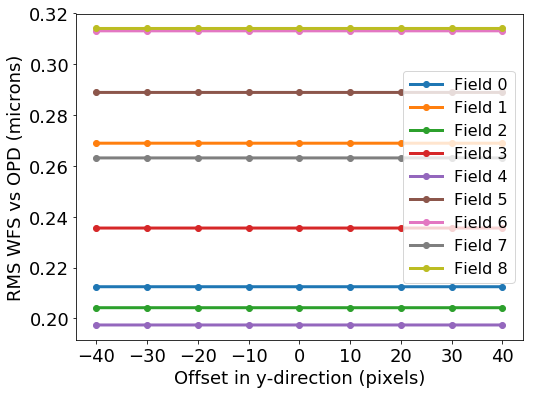

In [25]:
fig = plt.figure(figsize=(8,6))
for i in range(9):
    plt.plot(offset_array, np.sqrt(np.array(ssrFieldVals)[:, i]), '-o', lw=3, label='Field %i' % i)
plt.xlabel('Offset in y-direction (pixels)', size=18)
plt.ylabel('RMS WFS vs OPD (microns)', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.legend(fontsize=16)

Text(0.5, 1.0, 'Mean Errors in Each CCD')

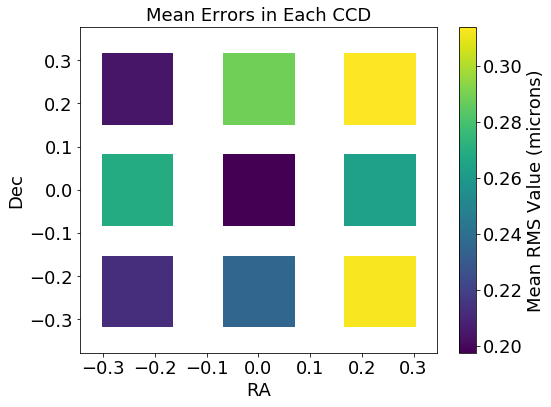

In [26]:
fig = plt.figure(figsize=(8,6))
plt.scatter(starCat['ra'], starCat['dec'], c=np.mean(np.sqrt(np.array(ssrFieldVals)), axis=0), s=5000, marker='s')
plt.xlabel('RA', size=18)
plt.ylabel('Dec', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
cbar = plt.colorbar()
cbar.set_label('Mean RMS Value (microns)', size=18)
cbar.ax.tick_params(labelsize=18)
plt.title('Mean Errors in Each CCD', size=18)

## Questions:

* This test seems to give lower errors overall compared to the original test with the star at the center of the chip. Is this expected? What could cause this? Would it be worth running this test over many parts of the chip?

* What values of errors are within requirements?